In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загружаем данные из файла
df = pd.read_csv("/Users/manya/Desktop/data/dz_3/train.csv")
# Пример данных
df

,TargetB,ID,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,...,PromCntCard36,PromCntCardAll,StatusCat96NK,StatusCatStarAll,DemAge,DemGender,DemHomeOwner,DemMedHomeValue,DemPctVeterans,DemMedIncome
0,0,14974,NaN,2,4,1,3,$17.00,$13.50,$9.25,...,8,13,A,0,NaN,F,U,$0,0,NaN
1,0,6294,NaN,1,8,0,3,$20.00,$20.00,$15.88,...,5,24,A,0,67.0,F,U,"$186,800",85,NaN
2,1,46110,$4.00,6,41,3,20,$6.00,$5.17,$3.73,...,11,22,S,1,NaN,M,U,"$87,600",36,"$38,750"
3,1,185937,$10.00,3,12,3,8,$10.00,$8.67,$8.50,...,6,16,E,1,NaN,M,U,"$139,200",27,"$38,942"
4,0,29637,NaN,1,1,1,1,$20.00,$20.00,$20.00,...,7,6,F,0,53.0,M,U,"$168,100",37,"$71,509"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,1,2796,$25.00,2,2,2,2,$10.00,$15.00,$15.00,...,12,11,N,0,NaN,M,H,"$68,200",38,"$45,909"
9682,0,184939,NaN,3,4,1,1,$10.00,$13.33,$11.50,...,15,13,A,0,NaN,U,H,"$71,900",35,"$50,530"
9683,1,184974,$10.00,9,14,5,7,$10.00,$8.78,$7.71,...,17,18,S,1,71.0,F,H,"$115,700",32,NaN
9684,0,184994,NaN,2,7,0,1,$5.00,$12.50,$7.43,...,6,16,A,0,NaN,M,H,"$106,300",32,"$62,717"


### Пункт 1

В файле «donation.csv» находится выборка с информацией об участниках программы пожертвования денег на нужды ветеранских организаций. Каждая запись – один человек из списка рассылки. У него есть социо-демографические признаки (пол, возраст, медианная оценка дохода в районе его проживания, является ли он домовладельцем и т.д. и т.д.), поведенческие признаки (агрегированные характеристики его ранних пожертвований типа GiftCount36 – число пожертвований за три года, GiftAmntLast – сумма последнего пожертвования, PromCntCard12 – число контактов с ним за год в рамках рекламной компании и т.д.). Также есть два отклика: флаг TargetB (пожертвовал или нет) и TargetD – сумма пожертвования (пропуск, если не жертвовал, иначе сумма в долларах). В рамках первой части задания нужно построить регрессионные модели (только по людям, кто пожертвовал деньги), объясняющие и прогнозирующи сумму пожертвования TargetD.

In [4]:
df_1 = df.copy()
df_1.set_index("ID", inplace=True)
df_1 = df_1[df_1["TargetB"] == 1]
df_1.drop(columns="TargetB", inplace=True)

Currency = ["GiftAvgLast", "GiftAvg36", "GiftAvgAll", "GiftAvgCard36", "DemMedHomeValue", "DemMedIncome"]
Character = ["StatusCat96NK", "DemGender", "DemHomeOwner"]
Numeric = ["GiftCnt36", "GiftCntAll", "GiftCntCard36", "GiftCntCardAll", "GiftTimeLast", "GiftTimeFirst",
           "PromCnt12", "PromCnt36", "PromCntAll", "PromCntCard12", "PromCntCard36", "PromCntCardAll",
           "StatusCatStarAll", "DemAge", "DemPctVeterans"]

# Удаляем символы $ и , с помощью str.replace()
for i in Currency + ["TargetD"]:
    column_to_transform = df_1[i]
    column_transformed = column_to_transform.str.replace("$", "", regex=False)
    column_transformed = column_transformed.str.replace(",", "", regex=False)
    column_numeric = pd.to_numeric(column_transformed)
    df_1[i] = column_numeric

# Преобразования категориальных переменных
for i in Character:
    print(i, df[i].unique())

ohe = OneHotEncoder(sparse=False)
ohe.fit(df_1[Character])

temp_df = pd.DataFrame(data=ohe.transform(df_1[Character]), columns=ohe.get_feature_names_out(), index = df_1.index)
df_1.drop(columns=Character, inplace=True)
df_1 = pd.concat([df_1, temp_df], axis=1)

Numeric += Currency

df_1

StatusCat96NK ['A' 'S' 'E' 'F' 'N' 'L']
DemGender ['F' 'M' 'U']
DemHomeOwner ['U' 'H']


,TargetD,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,...,StatusCat96NK_E,StatusCat96NK_F,StatusCat96NK_L,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U
ID,,,,,,,,,,,,,,,,,,,,,
46110,4.0,6,41,3,20,6.0,5.17,3.73,5.00,18,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
185937,10.0,3,12,3,8,10.0,8.67,8.50,8.67,9,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
112632,11.0,3,11,2,9,11.0,10.33,8.27,8.00,22,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
19094,40.0,1,3,0,1,35.0,35.00,28.33,NaN,17,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
102224,6.0,3,16,2,13,6.0,6.33,6.13,6.00,17,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184644,20.0,1,1,1,1,25.0,25.00,25.00,25.00,20,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
184690,20.0,1,1,0,0,15.0,15.00,15.00,NaN,20,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
184723,10.0,1,4,1,3,20.0,20.00,16.25,20.00,17,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


---

### Пункт 2
Выберите и сохраните в качестве проверочной выборки (holdout) 30% исходной выборки со стратификацией по отклику. Обратите внимание, что отклик непрерывный и его нужно дискретизировать. Число интервалов и метод дискретизации выберите самостоятельно. Постройте и визуализируйте гистограмму (или kde апроксимацию) для распределения отклика во всем исходном наборе, в проверочной и в тренировочной выборках.

In [5]:
df_2 = df_1.copy()

# Дискретизация отклика
y = df_2["TargetD"].to_frame()
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
est.fit(y)
print(est.bin_edges_)
df_2["TargetD"] = est.transform(y)

X = df_2.drop(columns="TargetD")
y = df_2["TargetD"].to_frame()

[array([  1.,  10.,  13.,  20., 200.])]


In [6]:
# Разделение на обучающую и тестовую выборку
def data_partition(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 123)
    return (X_train, y_train, X_test, y_test)

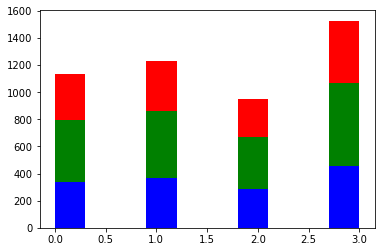

In [7]:
X_train, y_train, X_test, y_test = data_partition(X, y)

plt.hist(y, color = 'red')
plt.hist(y_train, color = 'green')
plt.hist(y_test, color = 'blue')
plt.show()

---

### Пункт 3
На этапе предобработки данных сделайте подстановку пропусков методом KnnImputer (neighbors=5) с сохранением бинарных признаков о том, какие переменные были проимпутированы. Преобразования категориальных переменных с помощью WOE, Target encoding, Threshold encoding и других методов, а также преобразование числовых переменных (для получения более симметричных распределений с помощью log или Box-Cox) приветствуется, но не обязательно.

In [8]:
# Преобразования числовых переменных
scaler = preprocessing.MinMaxScaler()

# тут мы настраиваем scaler только на тренировочных данных
scaler.fit(X_train[Numeric])

X_train[Numeric] = scaler.transform(X_train[Numeric])
X_test[Numeric] = scaler.transform(X_test[Numeric])

preprocessing.MinMaxScaler()

Преобразует элементы, масштабируя каждый элемент в заданный диапазон.

Эта оценка масштабирует и переводит каждую функцию по отдельности таким образом, чтобы она была в заданном диапазоне в тренировочном наборе, например, между нулем и единицей.

In [9]:
to_impute = []

for i in X_train.columns:
    if X_train[i].isnull().any() or X_test[i].isnull().any():
        to_impute.append(i)

print(to_impute)

['GiftAvgCard36', 'DemAge', 'DemMedIncome']


In [10]:
for i in to_impute:
    X_train[i + "_imputed"] = X_train[i].isna().astype(bool)
    X_test[i + "_imputed"] = X_test[i].isna().astype(bool)

knn_imp = KNNImputer(n_neighbors = 5)

knn_imp.fit(X_train[to_impute])

# нельзя заполнять пропущенные значения основываясь на тестовых данных
# заполняем пропущенные значения в тестовых данных основываясь только на знании о тренировочных данных
#knn_imp.fit(X_test[to_impute])

X_train[to_impute] = knn_imp.transform(X_train[to_impute])
X_test[to_impute] = knn_imp.transform(X_test[to_impute])

X_train

,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,GiftTimeFirst,...,StatusCat96NK_N,StatusCat96NK_S,DemGender_F,DemGender_M,DemGender_U,DemHomeOwner_H,DemHomeOwner_U,GiftAvgCard36_imputed,DemAge_imputed,DemMedIncome_imputed
ID,,,,,,,,,,,,,,,,,,,,,
90350,0.200000,0.055556,0.222222,0.073171,0.044444,0.08335,0.024724,0.067211,0.956522,0.204082,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False,True,False
128522,0.666667,0.522222,1.000000,0.658537,0.024444,0.05100,0.015187,0.043110,0.565217,0.469388,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,False,True,True
104891,0.133333,0.100000,0.111111,0.146341,0.044444,0.07500,0.023094,0.067211,0.565217,0.289796,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,False,False,True
24663,0.400000,0.144444,0.222222,0.121951,0.037778,0.07415,0.017443,0.062169,0.521739,0.269388,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,False,False,True
157106,0.266667,0.344444,0.444444,0.463415,0.080000,0.14000,0.038080,0.132759,0.695652,0.461224,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184496,0.266667,0.100000,0.333333,0.195122,0.022222,0.05000,0.015053,0.042001,0.652174,0.261224,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,False,False,False
123805,0.266667,0.122222,0.444444,0.195122,0.022222,0.02625,0.005182,0.018051,0.739130,0.248980,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,False,False,False
178334,0.466667,0.122222,0.333333,0.170732,0.022222,0.05715,0.015433,0.040337,0.478261,0.265306,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False,False,False


---

### Пункт 4
Произведите отбор важных переменных с помощью линейного регрессионного метода Backward OLS, перебрав все возможные сложности моделей в рамках вашего метода и выбрав лучшую по кросс-валидации c 5 блоками и MSE в качестве критерия. В пошаговых регрессионных методах для остановки и выбора следующего шага используйте R-квадрат, p- value или AIC на ваше усмотрение. Постройте график зависимости CV-MSE от сложности (число переменных или число компонент в модели), график трассы стандартизованных коэффициентов от сложности. Вертикальной линией на этих графиках обозначьте лучшую по CV сложность модели.

In [11]:
def backward_regression(X, y, threshold_out = 0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y.astype(float), sm.add_constant(pd.DataFrame(X[included].astype(float)))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        #mse = model.mse_model
        mse.append(model.mse_model)
        rs.append(model.rsquared)
        ols2 = LinearRegression()
        #ols_cv_mse = cross_val_score(ols2, X[included], y, scoring='neg_mean_squared_error', cv=10)
        ols_cv_mse = cross_val_score(ols2, X[included], y, scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True, random_state=42))
        ols_cv_mse_1.append(np.mean(-ols_cv_mse))
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {} with p-value {}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included, model

In [12]:
mse = []
rs = []
ols_cv_mse_1 = []
included, model = backward_regression(X_train, y_train)
included

Drop GiftCntCardAll with p-value 0.9229281743336645
Drop DemAge with p-value 0.6996600719840464
Drop DemPctVeterans with p-value 0.7172259335913113
Drop PromCntAll with p-value 0.5853067659385442
Drop GiftCntAll with p-value 0.6341400221722501
Drop PromCntCard12 with p-value 0.46035727681791805
Drop DemMedIncome_imputed with p-value 0.4274993425990067
Drop GiftAvgAll with p-value 0.42391811523049006
Drop GiftCntCard36 with p-value 0.38213207769761515
Drop DemMedIncome with p-value 0.2721406832035105
Drop StatusCat96NK_E with p-value 0.17576988409552594
Drop StatusCat96NK_L with p-value 0.48884426717611407
Drop DemGender_M with p-value 0.16396356179704832
Drop DemGender_U with p-value 0.8351690365965845
Drop DemAge_imputed with p-value 0.11396597638974869
Drop DemGender_F with p-value 0.10150656760606203
Drop DemHomeOwner_H with p-value 0.1098240861553545
Drop DemHomeOwner_U with p-value 0.2116785379915632
Drop PromCnt36 with p-value 0.05311375790456603
Drop PromCnt12 with p-value 0.087

['GiftCnt36',
 'GiftAvgLast',
 'GiftAvg36',
 'GiftAvgCard36',
 'GiftTimeLast',
 'GiftTimeFirst',
 'PromCntCard36',
 'PromCntCardAll',
 'StatusCatStarAll',
 'DemMedHomeValue',
 'StatusCat96NK_A',
 'StatusCat96NK_F',
 'StatusCat96NK_N',
 'StatusCat96NK_S',
 'GiftAvgCard36_imputed']

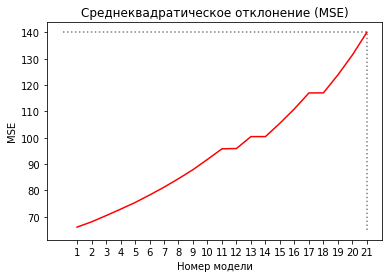

In [13]:
k = np.arange(1, 22)

plt.title("Среднеквадратическое отклонение (MSE)")
plt.xlabel("Номер модели")
plt.ylabel("MSE")
plt.xticks(k)
plt.plot([21, 21], [65, model.mse_model],linestyle = 'dotted', color="grey")
plt.plot([0,21], [model.mse_model, model.mse_model], linestyle= 'dotted', color="grey")
plt.plot(k, mse, color ="red")
plt.show()

Среднеквадратическое отклонение (MSE) - наиболее распространённый показатель рассеивания значений случайной величины относительно её математического ожидания. Обычно означает квадратный корень из дисперсии случайной величины, но иногда может означать тот или иной вариант оценки этого значения.

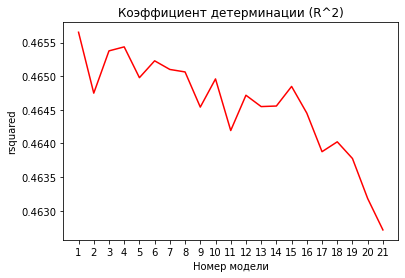

In [14]:
k = np.arange(1, 22)

plt.title("Коэффициент детерминации (R^2)")
plt.xlabel("Номер модели")
plt.ylabel("rsquared")
plt.xticks(k)
plt.plot(k, rs, color ="red")
plt.show()

Коэффициент детерминации (R^2) — это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости, то есть объясняющими переменными.
Всегда увеличисвается с включением новой переменной в модель.

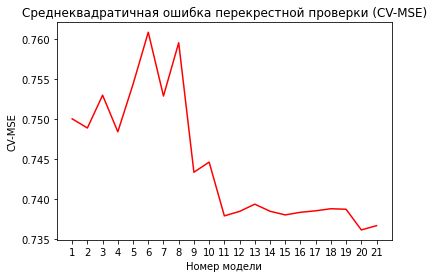

In [15]:
k = np.arange(1, 22)

plt.title("Среднеквадратичная ошибка перекрестной проверки (CV-MSE)")
plt.xlabel("Номер модели")
plt.ylabel("CV-MSE")
plt.xticks(k)
plt.plot(k, ols_cv_mse_1, color ="red")
plt.show()

Среднеквадратичная ошибка перекрестной проверки (CV-MSE) - мера точности модели, которая позволяет измерить, насколько хорошо модель может обобщаться на новые данные.

Снижение CV-MSE показывает, что модель стала более точной и способна лучше обобщаться на новые данные. CV-MSE можно использовать для сравнения различных моделей между собой. Если одна модель имеет меньшее значение CV-MSE, то можно считать, что она более точная и способна лучше обобщаться на новые данные. В принципе, снижение CV-MSE непосредственно отражает улучшение качества модели.

In [16]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                TargetD   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     193.7
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        09:43:53   Log-Likelihood:                -4252.2
No. Observations:                3390   AIC:                             8536.
Df Residuals:                    3374   BIC:                             8634.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.31

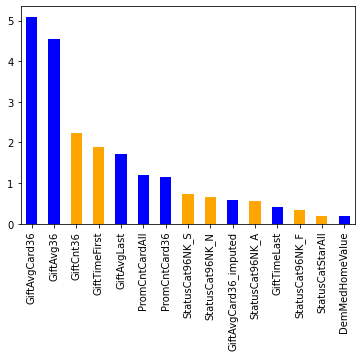

In [17]:
data = model.params.drop('const')
data.sort_values(key=lambda x : abs(x), ascending=False, inplace=True)
colors = ['blue' if value > 0 else 'orange' for value in data.values]
data.abs().plot.bar(color=colors)
plt.show()

---

### Пункт 5
Для лучшей выбранной сложности линейной модели с помощью бутстреппинга (100 бутстреп выборок размера 25% от исходной) постройте гистограммы (или kde аппроксимацию) распределения константы смещения в полученном регрессионном уравнении (константы b если регрессии y=ax+b) с указанием на графике среднего значения и 95% интервала. Аналогично оцените OOB ошибку MSE. Как она соотносится с лучшей кросс-валидационной ошибкой и ошибкой на проверочной части выборки?

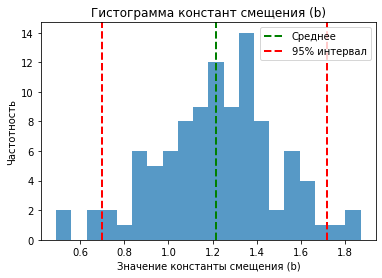

In [18]:
X, y = X_train[included], y_train

# генерируем 100 бутстреп выборок размера 25%
bootstrap_size = int(0.25 * X.shape[0])

X_bootstrap_samples = []
y_bootstrap_samples = []

for _ in range(100):
    X_sample, y_sample = resample(X, y, n_samples=bootstrap_size, random_state=None, replace=True)
    X_bootstrap_samples.append(X_sample)
    y_bootstrap_samples.append(y_sample)

intercepts = []

for i in range(100):
    lin_model = LinearRegression()
    
    # обучаем модель на каждой бутстреп выборке
    lin_model.fit(X_bootstrap_samples[i], y_bootstrap_samples[i])
    
    # получаем константу смещения (b) и сохраняем в список
    intercept = lin_model.intercept_[0]
    intercepts.append(intercept)

# строим гистограмму распределения констант смещения (b)
plt.hist(intercepts, bins=20, alpha=0.75)

# вычисляем среднее значение и границы 95% интервала
mean_intercept = np.mean(intercepts)
lower_bound = np.percentile(intercepts, 2.5)
upper_bound = np.percentile(intercepts, 97.5)

plt.axvline(mean_intercept, color='g', linestyle='dashed', linewidth=2)
plt.axvline(lower_bound, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2)

plt.title("Гистограмма констант смещения (b)")
plt.xlabel("Значение константы смещения (b)")
plt.ylabel("Частотность")

plt.legend(["Среднее", "95% интервал"])
plt.show()

Аналогично оцените OOB ошибку MSE. Как она соотносится с лучшей кросс-валидационной ошибкой и ошибкой на проверочной части выборки?

In [19]:
# Получаем набор данных X и y, где X - матрица признаков, а y - вектор целевой переменной
X, y = X_train, y_train

# Создаем экземпляр регрессора DecisionTreeRegressor
reg = DecisionTreeRegressor()

# Создаем экземпляр ансамбля BaggingRegressor с количеством репликаций 50
bagging_reg = BaggingRegressor(base_estimator=reg, n_estimators=50, bootstrap=True, random_state=42, oob_score=True)

# Обучаем модель на данных
bagging_reg.fit(X, y)

# Извлекаем значения константы смещения
#bias = bagging_reg.estimators_samples_[:, 0].mean(axis=0)
bias = []
for i in range(len(bagging_reg.estimators_samples_)):
    f = bagging_reg.estimators_samples_[i]
    f_1 = np.array(f)
    f_2 = f_1.mean(axis=0)
    bias.append(f_2)

# Строим гистограммы распределения константы смещения
#pd.Series(bias).hist(bins=10)

# Вычисляем OOB ошибку MSE
oob_error = mean_squared_error(y, bagging_reg.oob_prediction_)
print(f"OOB error: {oob_error:.4f}")

OOB error: 0.5269


In [20]:
X, y = X_train, y_train

# Создаем модель линейной регрессии
reg = LinearRegression()

# Создаем ансамбль BaggingRegressor на основе модели регрессии
bagging_reg = BaggingRegressor(base_estimator=reg, n_estimators=50, random_state=42)

# Выполняем кросс-валидацию на 5 блоках и оцениваем R^2
scores = cross_val_score(bagging_reg, X, y, cv=5, scoring='r2')

mean_r2_score = np.mean(scores)
mean_squared_err = -np.mean(cross_val_score(bagging_reg, X, y, cv=5, scoring='neg_mean_squared_error'))
print(f"Mean R^2 score: {mean_r2_score:.4f}")
print(f"Mean MSE: {mean_squared_err:.4f}")

Mean R^2 score: 0.4281
Mean MSE: 0.7646


In [21]:
# Получаем набор данных X и y, где X - матрица признаков, а y - вектор целевой переменной
X, y = X_test, y_test

# Создаем экземпляр регрессора DecisionTreeRegressor
reg = DecisionTreeRegressor()

# Создаем экземпляр ансамбля BaggingRegressor с количеством репликаций 50
bagging_reg = BaggingRegressor(base_estimator=reg, n_estimators=50, bootstrap=True, random_state=42, oob_score=True)

# Обучаем модель на данных
bagging_reg.fit(X, y)

# Извлекаем значения константы смещения
#bias = bagging_reg.estimators_samples_[:, 0].mean(axis=0)
bias = []
for i in range(len(bagging_reg.estimators_samples_)):
    f = bagging_reg.estimators_samples_[i]
    f_1 = np.array(f)
    f_2 = f_1.mean(axis=0)
    bias.append(f_2)

# Строим гистограммы распределения константы смещения
#pd.Series(bias).hist(bins=10)

# Вычисляем OOB ошибку MSE
oob_error = mean_squared_error(y, bagging_reg.oob_prediction_)
print(f"OOB error of test sample: {oob_error:.4f}")

OOB error of test sample: 0.6350


n_samples = 1000

oob_mse_errors = np.zeros(n_samples)  # массив для хранения ошибок MSE каждого наблюдения
oob_counts = np.zeros(n_samples)  # массив для хранения количества OOB предсказаний для каждого наблюдения

for i in range(100):
    lin_model = LinearRegression()
    
    # обучаем модель на текущей бутстреп выборке
    lin_model.fit(X_bootstrap_samples[i], y_bootstrap_samples[i])

    # находим OOB экземпляры данных (те, которые не были в текущей бутстреп выборке)
    mask = np.ones(n_samples, 

---

### Пункт 6
Используйте отобранные переменные для построения нелинейной модели прогнозирования числового отклика с помощью метода MLP (relu), при этом отбирая метапараметры с помощью метода HalvingGridSearchCV. 

Замечания:
- В PLS регрессиях для отбора переменных (после отбора числа компонент по кросс- валидации) используйте VIP статистику с любым порогом в диапазоне [0.5,1].
- Обратите внимание, что категориальные переменные можно либо включить в модель целиком (со всеми уровнями), либо не включать.
- Для однослойного MLP можно варьировать число нейронов и константу регуляризации, для GAM – константу регуляризации и число узлов в сплайне, для полиномиальной гребневой регрессии - константу регуляризации и степень полинома.

In [22]:
# Получаем набор данных X и y, где X - матрица признаков, а y - вектор целевой переменной
X, y = X_train[included], y_train

# Определяем набор значений метапараметров
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (150, 150)],
    'activation': ['relu'],
    'alpha': [0.001, 0.01, 0.1, 1],
}

# Создаем экземпляр MLPRegressor
mlp_regressor = MLPRegressor(random_state=42)

# Создаем экземпляр HalvingGridSearchCV
grid_search = HalvingGridSearchCV(mlp_regressor, param_grid, cv=5, factor=2, resource='n_samples')

# Обучаем модель на данных
grid_search.fit(X, y)

# Выводим лучшие параметры и значение метрики качества (R2-score)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (150, 150)}
Best score: 0.6152093869092665


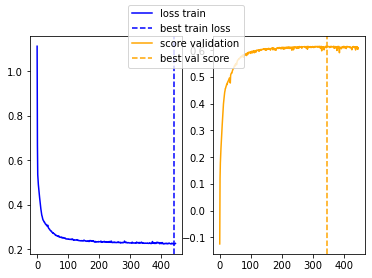

In [23]:
X, y = X_train[included], y_train


regr = MLPRegressor (hidden_layer_sizes=(25,25),
                     activation="tanh",
                     solver='adam',
                     alpha=1e-3, 
                     batch_size = "auto",
#                     learning_rate=' constant',
                     learning_rate_init=0.002, 
                     tol=1e-4, 
                     max_iter=3000, 
                     validation_fraction=0.3, 
                     early_stopping=True, 
                     n_iter_no_change=100)
regr.fit(X, y)

#лекция 8 слайд 75
#df.plot.scatter(x="age", y="wage", alpha=0.2)
#plt.scatter(X, regr.predict(X), color="r")

'''
# Определяем набор значений метапараметров
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (150, 150)],
    'activation': ['relu'],
    'alpha': [0.001, 0.01, 0.1, 1],
}

# Создаем экземпляр MLPRegressor
mlp_regressor = MLPRegressor(random_state=42)

# Создаем экземпляр HalvingGridSearchCV
grid_search = HalvingGridSearchCV(mlp_regressor, param_grid, cv=5, factor=2, resource='n_samples')

# Обучаем модель на данных
grid_search.fit(X, y)
'''

fig, axes = plt.subplots (ncols=2)
axes[0].plot(range(regr.n_iter_), np.array(regr.loss_curve_), label="loss train", color="blue")

best_tr_iter = np.argmin(regr.loss_curve_)
axes[0].axvline(best_tr_iter, color="blue", linestyle="--", label ="best train loss")
axes[1].plot(range(regr.n_iter_), regr.validation_scores_, label="score validation", color="orange")

best_val_iter = np.argmax(regr.validation_scores_)
axes[1].axvline(best_val_iter, color="orange", linestyle="--", label="best val score")
fig.legend (loc="upper center")

---

### Пункт 7
Постройте график – «решетку» перебора метапараметров, цветом указав качество моделей, а размером точек – число повторов для halving. Сравните CV, OOB и holdout оценки качества полученных линейных и нелинейных моделей, какие выводы из этого можно сделать?

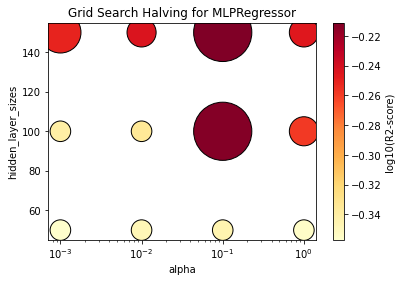

In [24]:
# Извлекаем информацию о решетке
results = grid_search.cv_results_

# Получаем массивы значений метапараметров
alphas = results["param_alpha"].data.astype(float)
layer_sizes = results["param_hidden_layer_sizes"].tolist()

layer_sizes_2 = []
for i in range(len(layer_sizes)):
    layer_sizes_2.append(layer_sizes[i][0])

# Получаем массивы значений среднего и стандартного отклонения метрики качества
mean_scores = results["mean_test_score"]
std_scores = results["std_test_score"]

# Вычисляем логарифм по основанию 10 от метрики качества
log_scores = np.log10(mean_scores)

# Вычисляем размер точек по числу повторов
sizes = results["n_resources"].astype(float)

# Отображаем точки, цветом указывая метрику качества, а размером точек - число повторов
plt.scatter(alphas, layer_sizes_2, c=log_scores, s=sizes, cmap="YlOrRd", edgecolors="black")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("hidden_layer_sizes")
plt.title("Grid Search Halving for MLPRegressor")
plt.colorbar(label="log10(R2-score)")
plt.show()